## Importing packages

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten
from sklearn.utils import shuffle

## Working on data

In [2]:
mnist = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist

# Normalizing the data
x_train = x_train / 255.0
x_test = x_test / 255.0


x_train = x_train.reshape([-1, 28, 28, 1])
x_test = x_test.reshape([-1, 28, 28, 1])


# Converting image to 32x32
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant").astype(np.float32)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2), (0, 0)), mode="constant").astype(np.float32)

# One_hot encodng of the labels 
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train, y_train = shuffle(x_train, y_train)

## Asserting and Visualizing Data

Size of data for train images: 60000
Size of data for test images: 10000
Image shape: (32, 32, 1)


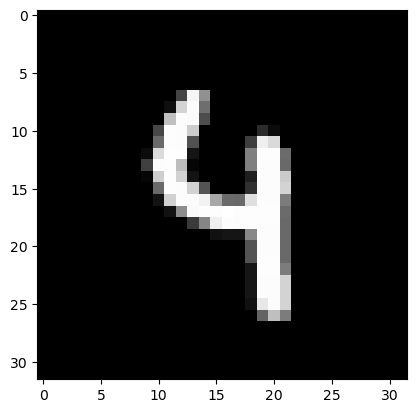

In [3]:
# Data Shapes
print("Size of data for train images:", len(x_train))
print("Size of data for test images:", len(x_test))

# Visualizing data
sample = x_train[5]
print("Image shape:", sample.shape)
plt.imshow(sample, cmap="gray")

## Defining Parameters

In [4]:
learning_rate = 0.001
batch_size = 128
keep_prob = 0.25
epochs = 10

## Model Implementation

In [5]:
def batches(x, y):
    batches_data = []
    for batch in range(0, len(x), batch_size):
        batches_data.append((x[batch:batch+batch_size], y[batch:batch+batch_size]))
    return batches_data

class MyModel(tf.Module):
    def __init__(self):
        # Weights
        self.conv1 = tf.Variable(tf.random.normal([5, 5, 1, 6]), name="conv1")
        self.conv2 = tf.Variable(tf.random.normal([5, 5, 6, 16]), name="conv2")
        self.fc1 = tf.Variable(tf.random.normal([400, 120]), name="fc1")
        self.fc2 = tf.Variable(tf.random.normal([120, 84]), name="fc2")
        self.fc3 = tf.Variable(tf.random.normal([84, 10]), name="fc3")
        
        # Bias
        self.bias1 = tf.Variable(tf.random.normal([6]), name="bias1")
        self.bias2 = tf.Variable(tf.random.normal([16]), name="bias2")
        self.bias4 = tf.Variable(tf.random.normal([120]), name="bias4")
        self.bias5 = tf.Variable(tf.random.normal([84]), name="bias5")
        self.bias6 = tf.Variable(tf.random.normal([10]), name="bias6")

    
    def __call__(self, x, keep_prob):
        # Layer 1: Convolutional Layer 1 - Input is 32x32x1 
        x = tf.nn.conv2d(x, self.conv1, strides=[1, 1, 1, 1], padding="VALID") # Input: 32x32x1 Output: 28x28x6 
        x = tf.nn.bias_add(x, self.bias1)
        x = tf.nn.relu(x)
        x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME") # Input: 28x28x6  Output: 14x14x6

        # Layer 2: Convolutional Layer 2 - Input is 14x14x6
        x = tf.nn.conv2d(x, self.conv2, strides=[1, 1, 1, 1], padding="VALID") # Input: 14x14x6 Output: 10x10x16 
        x = tf.nn.bias_add(x, self.bias2)
        x = tf.nn.relu(x)
        x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME") # Input: 10x10x16  Output: 5x5x16

        # Layer 3: Flatten Layer - Input is 5x5x16
        #x = Flatten()(x)
        x = tf.reshape(x, [-1, 5*5*16])

        # Layer 4: Fully Connected Layer 1 - Input: 400 Output: 120
        x = tf.matmul(x, self.fc1)
        x = tf.nn.bias_add(x, self.bias4)
        x = tf.nn.relu(x)

        # Layer 5: Fully Connected Layer 2 - Input: 120 Output: 84
        x = tf.matmul(x, self.fc2)
        x = tf.nn.bias_add(x, self.bias5)
        x = tf.nn.relu(x)
        #x = tf.nn.dropout(x, rate=1 - keep_prob)

        # Layer 6: Fully Connected Layer 3 - Input: 120 Output: 10
        x = tf.matmul(x, self.fc3)
        output = tf.nn.bias_add(x, self.bias6)

        return output

model = MyModel()

## Model Training

In [6]:
def compute_loss(labels, y):
    #epsilon = 1e-10
    #cross_entropy = -tf.reduce_sum(labels * tf.math.log(y + epsilon))
    loss_avg = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=labels))
    return loss_avg

def optimization(x, labels):
    with tf.GradientTape() as tape:
        logits = model(x, keep_prob)
        loss = compute_loss(labels, logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def compute_accuracy(labels, logits):
    correct_prediction = tf.equal(tf.argmax(labels, 1), tf.argmax(logits, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [7]:
optimizer = tf.optimizers.Adam(learning_rate)
batch_no = 1

for epoch in range(epochs):
    for batches_x, batches_y in batches(x_train, y_train):
        loss = optimization(batches_x, batches_y)
        logits = model(batches_x, keep_prob=1.0)
        accuracy = compute_accuracy(batches_y, logits)
        if batch_no % 50 == 0:
            print("Epoch:", epoch + 1, "...")
            print("Batch no:", batch_no)
            print("Validation loss:", loss.numpy())
            print("Validation accuracy:", accuracy.numpy())
        batch_no += 1

Epoch: 1 ...
Batch no: 50
Validation loss: 7212.2646
Validation accuracy: 0.1953125
Epoch: 1 ...
Batch no: 100
Validation loss: 3929.0781
Validation accuracy: 0.390625
Epoch: 1 ...
Batch no: 150
Validation loss: 2201.0488
Validation accuracy: 0.546875
Epoch: 1 ...
Batch no: 200
Validation loss: 1560.3729
Validation accuracy: 0.640625
Epoch: 1 ...
Batch no: 250
Validation loss: 1436.1372
Validation accuracy: 0.65625
Epoch: 1 ...
Batch no: 300
Validation loss: 894.0558
Validation accuracy: 0.7578125
Epoch: 1 ...
Batch no: 350
Validation loss: 862.1345
Validation accuracy: 0.7734375
Epoch: 1 ...
Batch no: 400
Validation loss: 1163.8776
Validation accuracy: 0.734375
Epoch: 1 ...
Batch no: 450
Validation loss: 1058.2859
Validation accuracy: 0.703125
Epoch: 2 ...
Batch no: 500
Validation loss: 794.21906
Validation accuracy: 0.75
Epoch: 2 ...
Batch no: 550
Validation loss: 397.25092
Validation accuracy: 0.8515625
Epoch: 2 ...
Batch no: 600
Validation loss: 392.64594
Validation accuracy: 0.890

In [8]:
tf.saved_model.save(model, "./model/")

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


In [9]:
logits = model(x_test, keep_prob=1)
accuracy = compute_accuracy(y_test, logits)

In [10]:
print("Test_accuracy:", accuracy.numpy())

Test_accuracy: 0.9509
